In [202]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import open3d as o3d
import nibabel as nib
import pandas
from matplotlib import cm
from sklearn.model_selection import train_test_split

In [3]:
FONT_TITLE_PLOT = {'family': 'sans-serif',
                   'color':  'black', 
                   'fontweight': 'bold',
                   'fontsize': 14}

FONT_LABEL_PLOT = {'family': 'sans-serif',
                   'color':  'black', 
                   'fontweight': 'normal',
                   'fontsize': 12}

FONT_LEGEND_PLOT = {'family': 'sans-serif',
                    'color':  'black', 
                    'fontweight': 'normal',
                    'fontsize': 12}


# Data import and partition

## Preprocessed data import
The data have already been preprocessed using the matlab class PSM (using the generateExportData function).

In [233]:
from sklearn.preprocessing import StandardScaler

# Load vectorized VTA matrix
dataset = scipy.io.loadmat('../../03_Data/ML_datasets/trilinear_interpolation/dataset_900um.mat')
table = pandas.read_csv('table.csv')

amp = table['amplitude']
X = np.clip(np.array(dataset['X']), 0, 1)
y = np.squeeze(np.array(dataset['y']))

X = np.hstack([X, np.expand_dims(amp.to_numpy(), axis=0).T])

# Load STN polygon
STN = o3d.io.read_point_cloud('templates/anatomyDISTALminimal.ply')

# Assign global variable
CONTAINER_AFFINE = np.squeeze(np.array(dataset['container_affine']))
CONTAINER_SHAPE = np.squeeze(np.array(dataset['container_shape']))

# Create partitions of training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)

scaler = StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print("min_test = ", np.min(X_test))
print("max_test = ", np.max(X_test))
print("min_train = ", np.min(X_train))
print("max_train = ", np.max(X_train))

newrow1 = np.ones((1, X.shape[1]))
newrow0 = np.zeros((1, X.shape[1]))
newrow0[0, 0] = 1

print("Number of features:    n = ", np.sum(np.max(X_train, axis=0), axis=0))

min_test =  -1.7785247907108475
max_test =  2.191798282148079e+17
min_train =  -1.7785247907108475
max_train =  27.22131517763341
Number of features:    n =  528046.168369395


# Plot functions

Before going into the generation of the maps, this section creates function useful to observe and compare the probabilistic maps.

### Reconstruction of a VTA
As the data (the VTA voxels values) are provided under a vectorized form, it is necessary to be able to reconstruct the map. The first feature of the matrix is the intercept term and is cannot be displayed with the rest of the map voxels.

In [163]:
def logit(x):
    eps = 1e-3
    return np.log((x+eps)/(1-x+eps))

def invlogit(x):
    return np.exp(x)/(1+np.exp(x))

def normalize(arr):
    arr_min = np.min(arr)
    return (arr-arr_min)/(np.max(arr)-arr_min)

def show_histogram(image):

    # create the histogram
    histogram, bin_edges = np.histogram(image, bins=256, range=(0, 1))

    # configure and draw the histogram figure
    plt.figure()
    plt.title("Grayscale Histogram")
    plt.xlabel("grayscale value")
    plt.ylabel("pixels")
    plt.xlim([0.0, 1.0])  # <- named arguments do not work here

    plt.plot(bin_edges[0:-1], histogram)  # <- or here
    plt.show()

def reconstruct(vector):
    # Function to reconstruct a vector into tensor based on the container shape

    intercept = vector[0]
    vector = vector[1:-1]
    tensor = np.reshape(vector, CONTAINER_SHAPE, order='F')

    return tensor, intercept

## Map plot
The plots of the map shall allow the vizualization of the map inside the MNI space. It is  important that the plot are easy to understand in order to give better insights about the stimulation sweet and sour spots. The function plot maps allows to plot the map in 3D (scatter) or see it in 2D as a image. In both cases the surrounding anatomy is displayed.

In [6]:
# Function used to visualize the different models
def plot_map(model,
             dim='2D', 
             plane='axial', 
             slice_index=int(CONTAINER_SHAPE[0]/2),
             view_angle=320, 
             marker='dot'):

    coef_tensor, coef_intercept = reconstruct(model.coef_)

    if dim == '2D':
        plot_slice(coef_tensor, slice_index, plane)
        
    elif dim == '3D':
        plot_cube(coef_tensor, view_angle, marker)

def plot_slice(tensor, slice_index, plane):
    # Function to plot a slice of the map on a 2D figure
    
    fig = plt.figure(figsize=(25/2.54, 25/2.54))
    ax = plt.axes()
    plt.ion()
    plt.set_cmap('seismic')

    if plane == 'axial':
        img = tensor[:, :, slice_index]
        max_img = np.max(np.abs(img))
        plt.pcolor(img, vmin=-max_img, vmax=max_img)
        plt.colorbar()
        ax.set_xlabel('Medial-lateral (mm)', fontdict=FONT_LABEL_PLOT)
        ax.set_ylabel('Posterior-anterior (mm)', fontdict=FONT_LABEL_PLOT)
        
    elif plane == 'sagittal':
        img = tensor[:, slice_index, :]
        max_img = np.max(np.abs(img))
        plt.pcolor(img, vmin=-max_img, vmax=max_img)
        plt.colorbar()
        ax.set_xlabel('Medial-lateral (mm)', fontdict=FONT_LABEL_PLOT)
        ax.set_ylabel('Inferior-superior (mm)', fontdict=FONT_LABEL_PLOT)
        
    elif plane == 'coronal':
        img = tensor[slice_index, :, :]
        max_img = np.max(np.abs(img))
        plt.pcolor(img, vmin=-max_img, vmax=max_img)
        plt.colorbar()
        ax.set_xlabel('Posterior-anterior (mm)', fontdict=FONT_LABEL_PLOT)
        ax.set_ylabel('Inferior-superior (mm)', fontdict=FONT_LABEL_PLOT)
        
    plt.show()

def plot_cube(cube, view_angle, marker):

    colors = cm.viridis(cube)
    alpha = normalize(np.power(np.abs(cube), 0.001))

    xx, yy, zz = np.indices(np.array(cube.shape))

    xx = xx.flatten()
    yy = yy.flatten()
    zz = zz.flatten()
    alpha = alpha.flatten()

    plt.figure(figsize=(20/2.54, 20/2.54))

    ax = plt.axes(projection='3d')
    ax.view_init(30, view_angle)
    ax.set_xlim(right=CONTAINER_SHAPE[0])
    ax.set_ylim(top=CONTAINER_SHAPE[1])
    ax.set_zlim(top=CONTAINER_SHAPE[2])

    if marker == 'dot':
        ax.scatter(xx, yy, zz, s=20, c=cube, alpha=alpha**2, cmap='seismic', depthshade=False)
        o3d.visualization.draw_geometries([STN])

    elif marker == 'voxel':
        #ax.voxels(xx, yy, zz, colors, alpha=filled)
        ax.voxels(xx, yy, zz, facecolors=colors, edgecolor='k', shade=False)
    
    plt.show()

## Results plot
The results plot will be used in order to assess the quality of a model. It includes:
   - Prediction vs ground truth on testing set,
   - Prediction vs ground truth on training set,
   - Coefficient of determination of between variable prediction and ground truth,
   - Residual plot and QQ plot of those.

In [221]:
# Function used to visualize the accuracy of a model on testing and training data
def plot_results(model, X_test, y_test, X_train, y_train, transformed=False):

    pred_test = model.predict(X_test)
    pred_train = model.predict(X_train)

    print(pred_test)
    if transformed:
        pred_test = invlogit(pred_test)
        pred_train = invlogit(pred_train)
        coef_deter_test = model.score(X_test, logit(y_test))
        coef_deter_train = model.score(X_train, logit(y_train))

    else:
        coef_deter_test = model.score(X_test, y_test)
        coef_deter_train = model.score(X_train, y_train)

    adj_coef_deter_test = 1-(1-coef_deter_test)*(X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)
    adj_coef_deter_train = 1-(1-coef_deter_train)*(X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1)

    # Create figure and axes
    fig, axs = plt.subplots(1, 2)

    # Set figure size and name
    fig.tight_layout()
    fig.suptitle('Clinical improvement prediction', y=0.8, fontsize=14, fontweight='bold')
    fig.set_size_inches(25/2.54, 25/2.54)

    # Set axe properties
    axs[0].set_title('Testing data', fontdict=FONT_TITLE_PLOT)
    axs[0].plot((0, 1), (0, 1), color='green', linestyle='dashed', linewidth=1.5)
    axs[0].set_xlabel('Prediction', fontdict=FONT_LABEL_PLOT)
    axs[0].set_ylabel('Ground Truth', fontdict=FONT_LABEL_PLOT)
    axs[0].scatter(pred_test, y_test, s=8)
    axs[0].set_aspect('equal', 'box')

    axs[1].set_title('Training data', fontdict=FONT_TITLE_PLOT)
    axs[1].plot((0, 1), (0, 1), color='green', linestyle='dashed', linewidth=1.5)
    axs[1].set_xlabel('Prediction', fontdict=FONT_LABEL_PLOT)
    axs[1].set_ylabel('Ground Truth', fontdict=FONT_LABEL_PLOT)
    axs[1].scatter(pred_train, y_train, s=8)
    axs[1].set_aspect('equal', 'box')

    if False:# transformed:
        axs[0].set_xlim([-0.05, 1.05])
        axs[0].set_ylim([-0.05, 1.05])

        axs[1].set_xlim([-0.05, 1.05])
        axs[1].set_ylim([-0.05, 1.05])


    # Show figure
    plt.show()

    # Print the value of the R2
    print("Coefficient of determination (R²):")
    print("     - testing  :    ", coef_deter_test)
    print("     - training :    ", coef_deter_train)


## Export map

In [8]:
def save_map(model):
    ni_img = nib.Nifti1Image(reconstruct(model.coef_)[0], CONTAINER_AFFINE)
    nib.save(ni_img, 'map.nii.gz')

# Probabilistic Stimulation for deep brain stimulation

## Linear Models
### Linear regression (response variable in unit interval)
Both linear regression (with response variable in unit interval or real numbers) show the typical signs of overfiting. The training accuracy is very high and generalize very poorly. The map also shows that the learned parameters completely ignored the regions stimulated by a lot of VTAs and gives more importance to the surrounding voxels stimulated by less voxels.

In [200]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model = model.fit(X_train, y_train)

plot_results(model, X_test, y_test, X_train, y_train, transformed=False)
#plot_map(model, dim='3D')
plot_map(model, dim='2D')

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

### Linear regression (response variable transformed in real positive)

In [201]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model = model.fit(X_train, logit(y_train))

plot_results(model, X_test, y_test, X_train, y_train, transformed=True)
plot_map(model, dim='3D')
plot_map(model, dim='2D')

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

### Bayesian Linear regression

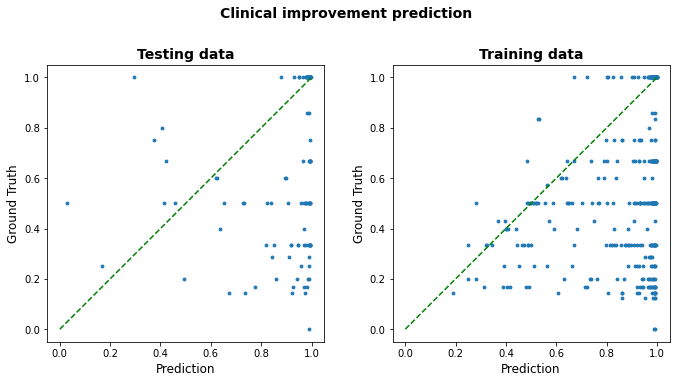

Coefficient of determination (R²):
     - testing  :     0.2628527764271723
     - training :     0.340416243220961


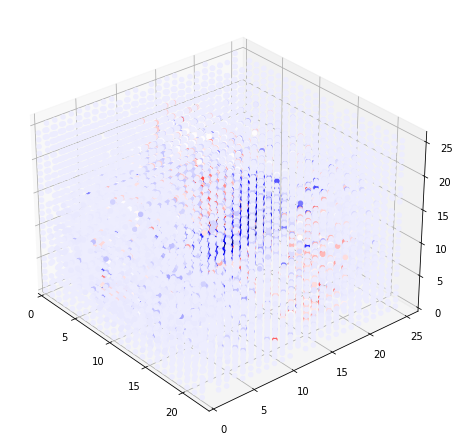

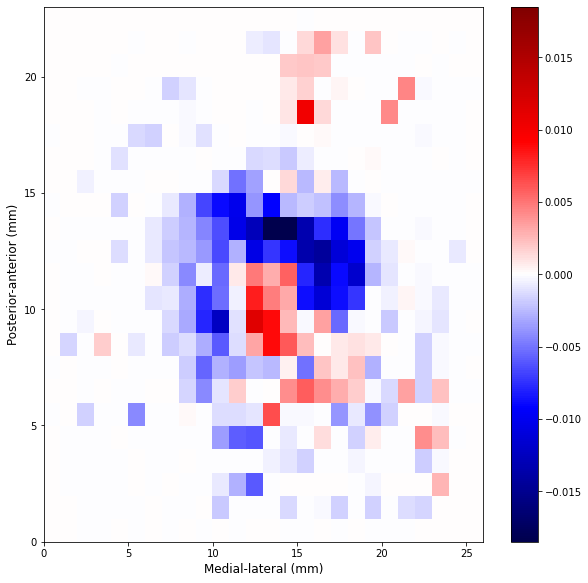

In [192]:
from sklearn.linear_model import BayesianRidge

model = BayesianRidge(alpha_1=1e-3, alpha_2=1e-3, lambda_1=1e-3, lambda_2=1e-3)
model.fit(X_train, logit(y_train))
plot_results(model, X_test, y_test, X_train, y_train, transformed=True)
plot_map(model, dim='3D')
plot_map(model, dim='2D')

### Lasso regression

/home/brainstimmaps/.conda/envs/PSM/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.21431977107002353, tolerance: 0.006797926588334554
  positive)


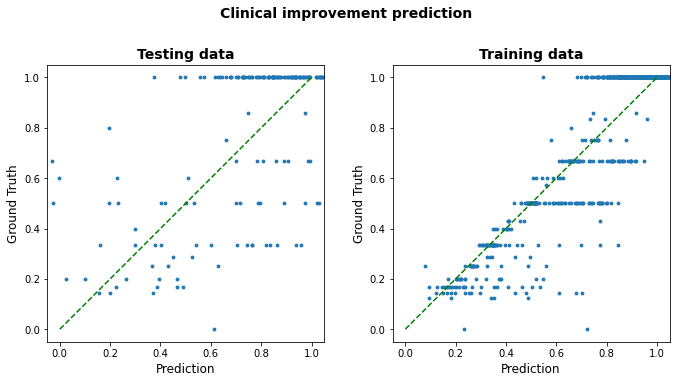

Coefficient of determination (R²):
     - testing  :     -3.8781440287699906e+25
     - training :     0.8346723617148009


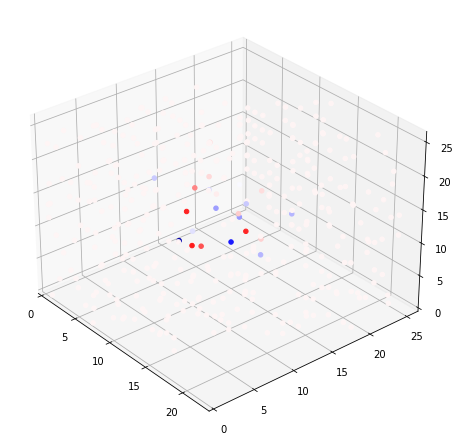

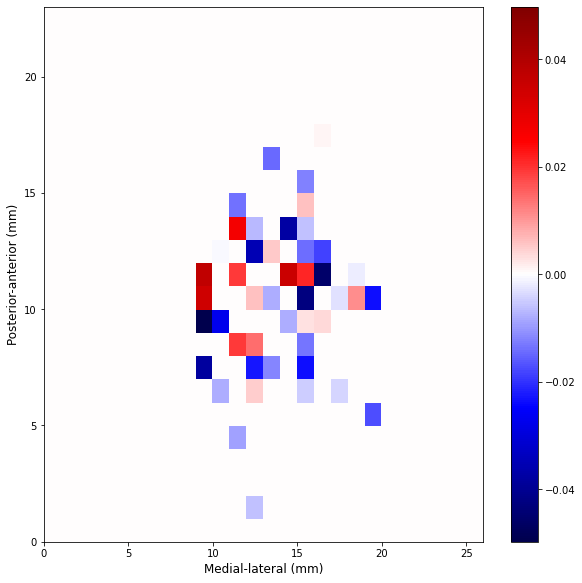

In [196]:
from sklearn.linear_model import Lasso

model = Lasso(alpha=0.0008, random_state=0)
model = model.fit(X_train, (y_train))
plot_results(model, X_test, y_test, X_train, y_train, transformed=False)
plot_map(model, dim='3D')
plot_map(model, dim='2D')

### Elastic Nets

/home/brainstimmaps/.conda/envs/PSM/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 524.9785850038836, tolerance: 0.9669128285809552
  positive)
/home/brainstimmaps/.conda/envs/PSM/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  
/home/brainstimmaps/.conda/envs/PSM/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


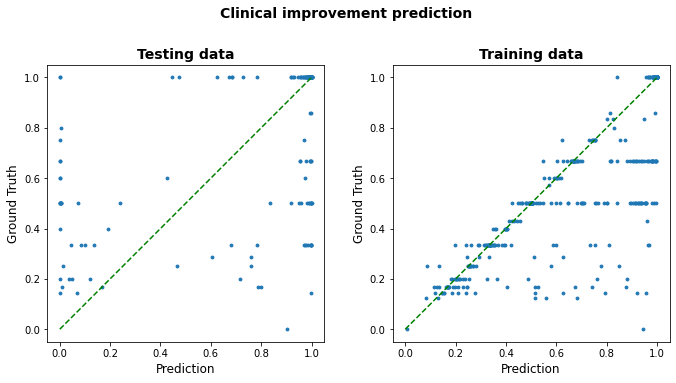

Coefficient of determination (R²):
     - testing  :     -1.5175764044865134e+28
     - training :     0.865410032451502


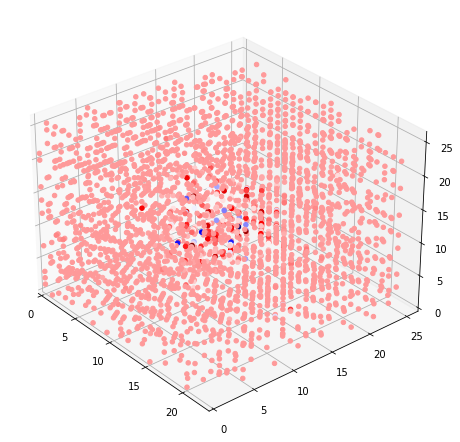

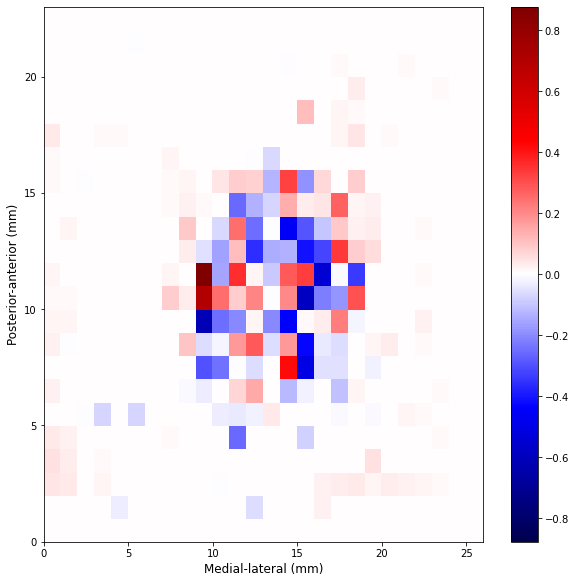

In [197]:
from sklearn.linear_model import ElasticNet

model = ElasticNet(random_state=12, alpha=0.01, l1_ratio=0.05)
model = model.fit(X_train, logit(y_train))

plot_results(model, X_test, y_test, X_train, y_train, transformed=True)
plot_map(model, dim='3D')
plot_map(model, dim='2D')

## Generalized Linear Models
### Logistic Regression
Cannot be used with a continuous response variable because it relies on the Bernoulli distribution which is not applicable to a continuous variable as the clinical improvement. But by rounding the response variable to a binary outcome in the training set and then evaluating the probability of the response against the continuous test response it is possible to use this model

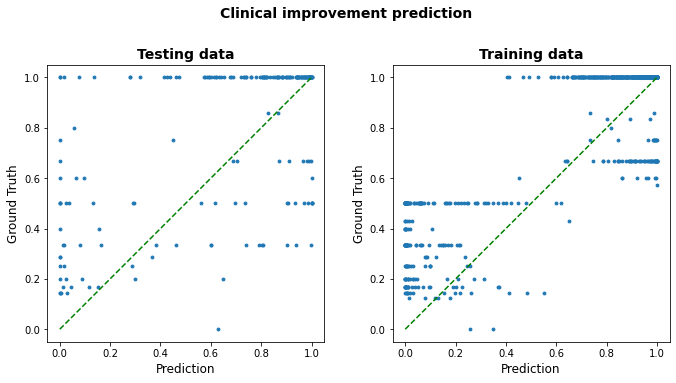

Coefficient of determination (R²):
     - testing  :     0.2979175128000631
     - training :     0.7559428422769907


In [218]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=10000, tol=1e-6, C=0.08, penalty='l2', dual=False, solver='newton-cg', class_weight='balanced')
model = model.fit(X_train, np.round(y_train).astype('int'))

pred_test = model.predict_proba(X_test)
pred_train = model.predict_proba(X_train)

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(pred_test[:, 1], y_test)
coef_deter_test = r_value**2

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(pred_train[:, 1], y_train)
coef_deter_train = r_value**2

# Create figure and axes
fig, axs = plt.subplots(1, 2)

# Set figure size and name
fig.tight_layout()
fig.suptitle('Clinical improvement prediction', y=0.8, fontsize=14, fontweight='bold')
fig.set_size_inches(25/2.54, 25/2.54)

# Set axe properties
axs[0].set_title('Testing data', fontdict=FONT_TITLE_PLOT)
axs[0].plot((0, 1), (0, 1), color='green', linestyle='dashed', linewidth=1.5)
axs[0].set_xlabel('Prediction', fontdict=FONT_LABEL_PLOT)
axs[0].set_ylabel('Ground Truth', fontdict=FONT_LABEL_PLOT)
axs[0].scatter(pred_test[:, 1], y_test, s=8)
axs[0].set_aspect('equal', 'box')
axs[0].set_xlim([-0.05, 1.05])
axs[0].set_ylim([-0.05, 1.05])

axs[1].set_title('Training data', fontdict=FONT_TITLE_PLOT)
axs[1].plot((0, 1), (0, 1), color='green', linestyle='dashed', linewidth=1.5)
axs[1].set_xlabel('Prediction', fontdict=FONT_LABEL_PLOT)
axs[1].set_ylabel('Ground Truth', fontdict=FONT_LABEL_PLOT)
axs[1].scatter(pred_train[:, 1], y_train, s=8)
axs[1].set_aspect('equal', 'box')
axs[1].set_xlim([-0.05, 1.05])
axs[1].set_ylim([-0.05, 1.05])

# Show figure
plt.show()

# Print the value of the R2
print("Coefficient of determination (R²):")
print("     - testing  :    ", coef_deter_test)
print("     - training :    ", coef_deter_train)


### Beta Regression

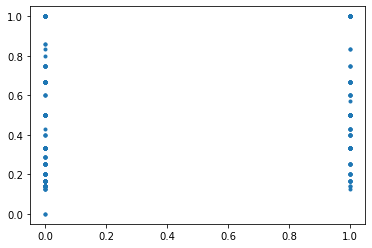

In [219]:
from scipy.optimize import minimize
from scipy.special import loggamma
from scipy.special import expit, logit
from sklearn.feature_selection import VarianceThreshold

def logLikelihood(params, y, X):
    b = np.array(params[0:-1])      # the beta parameters of the regression model
    phi = params[-1]                # the phi parameter
    mu = expit(np.dot(X,b))

    eps = 1e-6                      # used for safety of the gamma and log functions avoiding inf
    res = - np.sum(loggamma(phi+eps) # the log likelihood
                   - loggamma(mu*phi+eps)
                   - loggamma((1-mu)*phi+eps)
                   + (mu*phi-1)*np.log(y+eps)
                   + ((1-mu)*phi-1)*np.log(1-y+eps))

    return res

def penalty(params):
    return np.linalg.norm(params, ord=1, axis=0)

def costFunction(params, y, X):
    return logLikelihood(params, y, X) + penalty(params)

feature_selection = VarianceThreshold(threshold=(.8 * (1 - .8)))
X_train_selected_feat = feature_selection.fit_transform(X_train)

x0 = np.ones(X_train_selected_feat.shape[1] + 1)
bounds = ((None, None),) * X_train_selected_feat.shape[1] + ((0, None),)
options = {"disp": True}

res = minimize(costFunction, x0=x0, args=(np.squeeze(y_train), X_train_selected_feat), bounds=bounds, options=options)

b = np.array(res.x[0:X_train_selected_feat.shape[1]])   # optimal regression parameters
y_ = expit(np.dot(X_train_selected_feat,b))             # predictions
plt.plot(y_, y_train, ".")

## Support Vector Regression
### Sigmoid kernel

In [ ]:
from sklearn.svm import SVR
model = SVR(kernel='sigmoid')
#kernel{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’,
model = model.fit(X_train, logit(y_train))
plot_results(model, X_test, logit(y_test), X_train, logit(y_train), transformed=True)

### RBF kernel

In [ ]:
from sklearn.svm import SVR
model = SVR(kernel='rbf')
#kernel{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’,
model = model.fit(X_train, logit(y_train))
plot_results(model, X_test, logit(y_test), X_train, logit(y_train), transformed=True)

## Ensembling
### Bagging Decision Tree

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s finished


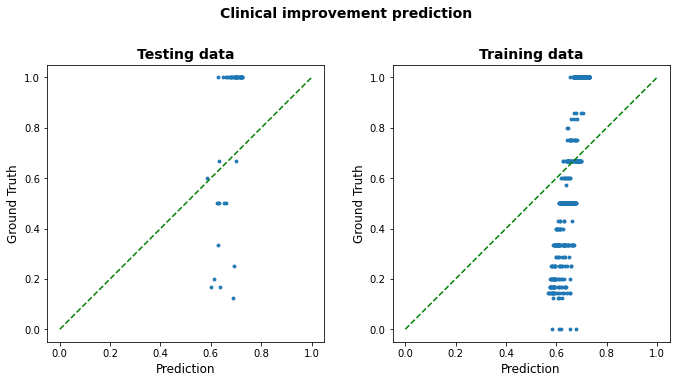

Coefficient of determination (R²):
     - testing  :     -1.7715209787324588
     - training :     -0.9860490478421213


In [182]:
from sklearn.ensemble import BaggingRegressor

model = BaggingRegressor(n_estimators=100, random_state=0, verbose=1, max_samples=0.6,bootstrap_features=True, max_features=0.2)
model = model.fit(X_train, y_train)
plot_results(model, X_test, y_test, X_train, y_train, transformed=True)

In [66]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn import set_config

steps = [
    ("preprocessing", StandardScaler()),
    ("classifier", LogisticRegression()),
]
pipe = Pipeline(steps)


clf = Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1"))),
  ('classification', RandomForestClassifier())
])
clf.fit(X, y)

NameError: name 'SelectFromModel' is not defined

## Pipeline
### Dimensionality reduction

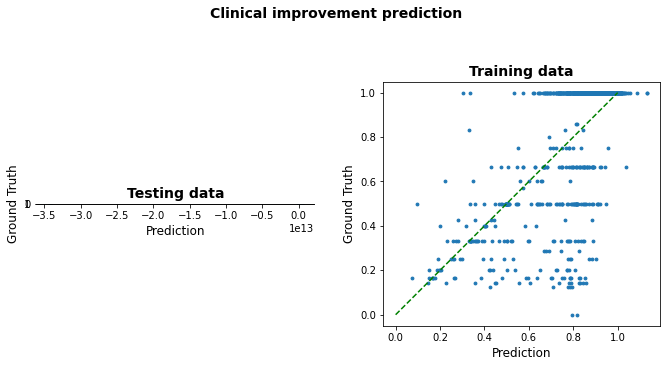

Coefficient of determination (R²):
     - testing  :     -6.690328948699165e+25
     - training :     0.4348837795888695
Slope:
     - testing  :     -6.690328948699165e+25
     - training :     0.4348837795888695


In [220]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn import set_config

steps = [("centering", StandardScaler()), ("reduce_dim", PCA(n_components=150)), ("regressor", Lasso(alpha=0.001))]
model = Pipeline(steps)
set_config(display="diagram")
model.fit(X_train, y_train)
plot_results(model, X_test, y_test, X_train, y_train, transformed=False)

### Feature selection

/home/brainstimmaps/.conda/envs/PSM/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4642745768111496, tolerance: 0.03226223440663354
  positive)


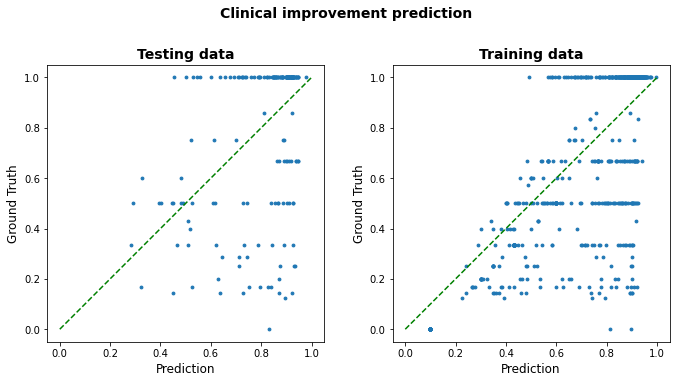

Coefficient of determination (R²):
     - testing  :     0.1261140841939672
     - training :     0.8578724947100119


AttributeError: 'Pipeline' object has no attribute 'coef_'

In [109]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR
from sklearn.feature_selection import SelectFromModel
from sklearn import set_config
from sklearn.linear_model import Lasso
from sklearn.svm import SVR

steps = [("feature selection", SelectFromModel(estimator=Lasso(alpha = 0.0001, max_iter=1e4))
), ("regressor", SVR(kernel="rbf"))]
model = Pipeline(steps)
set_config(display="diagram")
model.fit(X_train, np.squeeze(y_train.T))
plot_results(model, X_test, y_test, X_train, y_train)
plot_map(model, dim='2D')

In [22]:
save_map(model)

In [56]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_regression
from scipy.special import expit, logit

X, y, coef = make_regression(n_samples=1000,
                             n_features=5,
                             n_informative=3,
                             noise=5.0,
                             coef=True,
                             random_state=0)

# mapping the data to the interval [0,1]
y = expit(y/50)   # the factor 50 just scales the data appropriately

print("The data was generated with the following coefficients:")
print(coef)

The data was generated with the following coefficients:
[10.71453179  0.          0.         66.49948238 41.20593377]


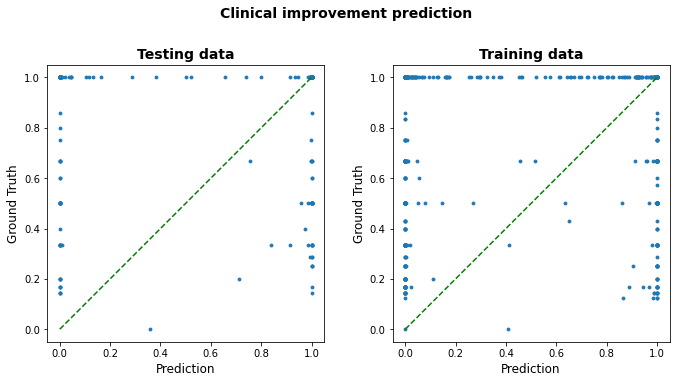

Coefficient of determination (R²):
     - testing  :     0.003941574395360139
     - training :     0.0020879086210193747
Number of features selected:   n =  700


In [225]:
from scipy.optimize import minimize
from sklearn.linear_model import Lasso
from scipy.special import loggamma
from scipy.special import expit, logit
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA

def logLikelihood(params, y, X):
    b = np.array(params[0:-1])      # the beta parameters of the regression model
    phi = params[-1]                # the phi parameter
    mu = expit(np.dot(X,b))

    eps = 1e-6                      # used for safety of the gamma and log functions avoiding inf
    res = - np.sum(loggamma(phi+eps) # the log likelihood
                   - loggamma(mu*phi+eps)
                   - loggamma((1-mu)*phi+eps)
                   + (mu*phi-1)*np.log(y+eps)
                   + ((1-mu)*phi-1)*np.log(1-y+eps))

    return res

def penalty(params, C=0, C1_ratio=0.5):
    return C * C1_ratio * np.linalg.norm(params, ord=1, axis=0) + C * (1 - C1_ratio) * np.linalg.norm(params, ord=2, axis=0)

def costFunction(params, y, X):
    return logLikelihood(params, y, X) + penalty(params)

# feature_selection = VarianceThreshold()
feature_selection = PCA(n_components=700)
feature_selection = feature_selection.fit(X_train)


X_train_selected_feat = feature_selection.transform(X_train)
X_test_selected_feat = feature_selection.transform(X_test)

x0 = np.ones(X_train_selected_feat.shape[1] + 1)
bounds = ((None, None),) * X_train_selected_feat.shape[1] + ((0, None),)
options = {"disp": True}

res = minimize(costFunction, x0=x0, args=(np.squeeze(y_train), X_train_selected_feat), bounds=bounds, options=options)

b = np.array(res.x[0:X_train_selected_feat.shape[1]])   # optimal regression parameters
pred_train = expit(np.dot(X_train_selected_feat, b))             # predictio
pred_test = expit(np.dot(X_test_selected_feat, b))             # predictions

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(pred_test, y_test)
coef_deter_test = r_value**2

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(pred_train, y_train)
coef_deter_train = r_value**2

# Create figure and axes
fig, axs = plt.subplots(1, 2)

# Set figure size and name
fig.tight_layout()
fig.suptitle('Clinical improvement prediction', y=0.8, fontsize=14, fontweight='bold')
fig.set_size_inches(25/2.54, 25/2.54)

# Set axe properties
axs[0].set_title('Testing data', fontdict=FONT_TITLE_PLOT)
axs[0].plot((0, 1), (0, 1), color='green', linestyle='dashed', linewidth=1.5)
axs[0].set_xlabel('Prediction', fontdict=FONT_LABEL_PLOT)
axs[0].set_ylabel('Ground Truth', fontdict=FONT_LABEL_PLOT)
axs[0].scatter(pred_test, y_test, s=8)
axs[0].set_aspect('equal', 'box')
axs[0].set_xlim([-0.05, 1.05])
axs[0].set_ylim([-0.05, 1.05])

axs[1].set_title('Training data', fontdict=FONT_TITLE_PLOT)
axs[1].plot((0, 1), (0, 1), color='green', linestyle='dashed', linewidth=1.5)
axs[1].set_xlabel('Prediction', fontdict=FONT_LABEL_PLOT)
axs[1].set_ylabel('Ground Truth', fontdict=FONT_LABEL_PLOT)
axs[1].scatter(pred_train, y_train, s=8)
axs[1].set_aspect('equal', 'box')
axs[1].set_xlim([-0.05, 1.05])
axs[1].set_ylim([-0.05, 1.05])

# Show figure
plt.show()

# Print the value of the R2
print("Coefficient of determination (R²):")
print("     - testing  :    ", coef_deter_test)
print("     - training :    ", coef_deter_train)

# Print the value of the R2
print("Number of features selected:   n = ", X_train_selected_feat.shape[1])

## PCA feature reduction

[ 9.10364358e-01  8.50861463e-01  8.05291222e-01  7.13903640e-01
  7.71769913e-01  9.75183604e-01  7.22709303e-01  8.03381107e-01
  4.42386055e-01  6.10648065e-01  7.35242918e-01  7.70813678e-01
  9.35069276e-01  9.29852554e-01  8.81919981e-01 -3.25293072e+09
  9.11533341e-01  9.87896937e-01  7.53440058e-01  8.28800679e-01
  6.50822084e-01  8.20445743e-01  8.18985437e-01  7.21478806e-01
 -1.82747943e+07  6.68230044e-01  9.13720182e-01  8.13746521e-01
 -4.03758263e+01  8.48110858e-01  8.31180465e-01  3.12997042e-01
  7.92994003e-01  9.56388031e-01  8.64983784e-01  7.59080163e-01
  2.03930330e+06  8.75981513e-01  4.84976839e-01  7.35391813e-01
  8.16992684e-01  6.97245962e-01  8.96272612e-01  9.20584608e-02
  8.22924074e-01  6.68744648e-01  9.47933316e-01  9.74532430e-01
  8.67273576e-01  7.90131508e-01  3.92283309e-01  3.81715270e+02
  7.45657349e-01  7.75039532e-01  7.82556870e-01  1.81500376e+04
  8.59698132e-01  1.19782266e+00  9.93634445e-01  9.84860813e-01
  7.07994220e-01  8.80311

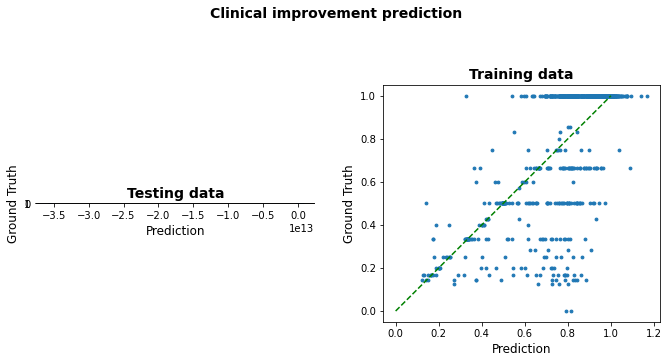

Coefficient of determination (R²):
     - testing  :     -7.216892805035788e+25
     - training :     0.49198624404847513


ValueError: cannot reshape array of size 198 into shape (29,31,32)

In [231]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

from sklearn.decomposition import PCA




steps = [("preproc", StandardScaler()), ("reduce_dim", PCA(n_components=200)), ("regressor", LinearRegression())]
model = Pipeline(steps)
set_config(display="diagram")
model.fit(X_train, y_train)
plot_results(model, X_test, y_test, X_train, y_train, transformed=False)

plot_map(model.named_steps['regressor'])

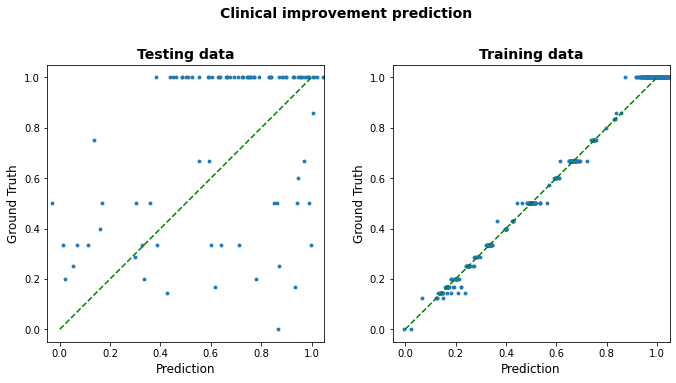

Coefficient of determination (R²):
     - testing  :     -1.9813458757480387e+26
     - training :     0.9948620994559665


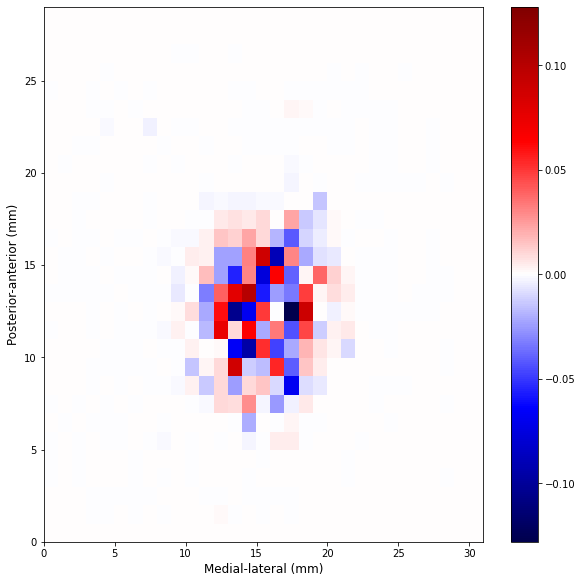

In [211]:
from sklearn.cross_decomposition import PLSRegression

pls = PLSRegression(n_components=200)
pls.fit(X_train, y_train)
plot_results(pls, X_test, y_test, X_train, y_train, transformed=False)

plot_map(pls)